# Loading necessary Libraries

In [ ]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter
from datetime import timedelta
from IPython.display import display
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

# Loading the data

In [ ]:
df = pd.read_excel('/content/data.xlsx')

In [ ]:
df.head()

,Unnamed: 0,bought_at,valid_from,product_validity,customer_category_name,id,ticket_price,product_id,product_name
0,0,2017-08-30 07:54:00,2017-12-29,6.0,Erwachsen,13247,293.0,47814-47809,6 Tage
1,1,2017-11-24 07:57:24,2017-12-22,2.0,Erwachsen,14586,106.0,47810-47809,2 Tage
2,2,2017-12-03 13:17:36,2017-12-02,1.0,Einh Erwachsen,14764,47.0,47809-47811,1 Tag
3,3,2017-12-03 13:17:40,2017-12-02,1.0,Einh Erwachsen,14764,47.0,47809-47811,1 Tag
4,4,2017-12-03 15:56:52,2017-12-02,1.0,Erwachsen,14773,56.0,47809-47809,1 Tag


# Quick look at the data


In [ ]:
print('\nLoaded dataframe with shape:', df.shape)

pd.set_option('display.max_columns', None)
print('Columns:', list(df.columns))

print('\nFirst rows:')
print(df.head().to_string())

print('\nData types:')
print(df.dtypes)


Loaded dataframe with shape: (117940, 9)
Columns: ['Unnamed: 0', 'bought_at', 'valid_from', 'product_validity', 'customer_category_name', 'id', 'ticket_price', 'product_id', 'product_name']

First rows:
   Unnamed: 0           bought_at valid_from  product_validity customer_category_name     id ticket_price   product_id product_name
0           0 2017-08-30 07:54:00 2017-12-29               6.0              Erwachsen  13247        293.0  47814-47809       6 Tage
1           1 2017-11-24 07:57:24 2017-12-22               2.0              Erwachsen  14586        106.0  47810-47809       2 Tage
2           2 2017-12-03 13:17:36 2017-12-02               1.0         Einh Erwachsen  14764         47.0  47809-47811        1 Tag
3           3 2017-12-03 13:17:40 2017-12-02               1.0         Einh Erwachsen  14764         47.0  47809-47811        1 Tag
4           4 2017-12-03 15:56:52 2017-12-02               1.0              Erwachsen  14773         56.0  47809-47809        1 Tag

Dat

# Convert columns to proper types and handle the non values

In [ ]:
df['bought_at'] = pd.to_datetime(df['bought_at'])
df['valid_from'] = pd.to_datetime(df['valid_from'], dayfirst=True)
df['ticket_price'] = pd.to_numeric(df['ticket_price'], errors='coerce')
df['product_validity'] = pd.to_numeric(df['product_validity'], errors='coerce')

df['ticket_price'] = pd.to_numeric(df['ticket_price'].astype(str).str.replace(',', '.').str.strip(), errors='coerce')
df['product_validity'] = pd.to_numeric(df['product_validity'].astype(str).str.strip(), errors='coerce')


df = df.dropna(subset=['ticket_price', 'product_validity'])
df = df.dropna(subset=['bought_at', 'valid_from'])

# KPI

In [ ]:
total_tickets = len(df)
total_revenue = df['ticket_price'].sum()
average_ticket_price = df['ticket_price'].mean()
unique_customers = df['id'].nunique()
average_product_validity = df['product_validity'].mean()

print(f"Total tickets sold: {total_tickets}")
print(f"Total revenue: {total_revenue}")
print(f"Average ticket price: {average_ticket_price:.2f}")
print(f"Unique customers: {unique_customers}")
print(f"Average ticket validity (days): {average_product_validity:.1f}")
category_sales = df.groupby('customer_category_name')['ticket_price'].agg(['count','sum','mean']).reset_index()
product_sales = df.groupby('product_name')['ticket_price'].agg(['count','sum','mean']).reset_index()
print("\nCategory sales:")
print(category_sales)
print("\nProduct sales:")
print(product_sales)


Total tickets sold: 117746
Total revenue: 11897354.459999999
Average ticket price: 101.04
Unique customers: 26258
Average ticket validity (days): 2.3

Category sales:
  customer_category_name  count         sum        mean
0         Einh Erwachsen  11882   558559.99   47.008920
1        Einh Jugendlich    572    23117.39   40.415017
2              Einh Kind   2567    63123.00   24.590183
3              Erwachsen  77560  9123205.09  117.627709
4             Jugendlich   5634   678111.15  120.360517
5                   Kind  19531  1451237.84   74.304329

Product sales:
   product_name  count         sum        mean
0         1 Tag  77403  3692810.11   47.708876
1       10 Tage    179    68078.00  380.324022
2       11 Tage    112    46490.50  415.093750
3       12 Tage    152    68579.00  451.177632
4       13 Tage    296   137647.50  465.025338
5       14 Tage    112    54006.00  482.196429
6       15 Tage     22    11753.00  534.227273
7       16 Tage      6     3119.00  519.833333
8 

# Trends Over Time

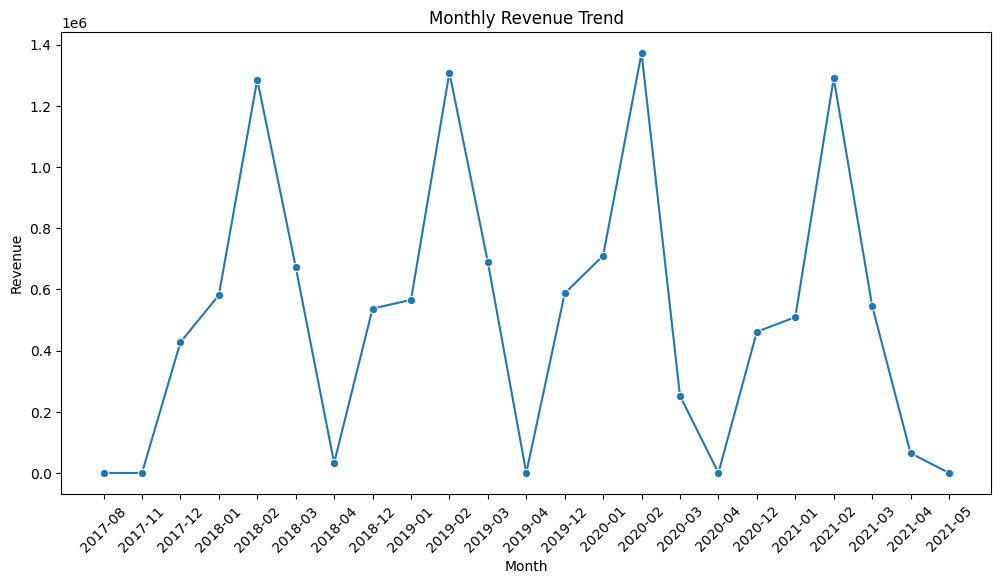

In [ ]:
#Monthly Revenue Trend

df['month'] = df['bought_at'].dt.to_period('M').astype(str)
monthly_sales = df.groupby('month')['ticket_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='month', y='ticket_price', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.show()


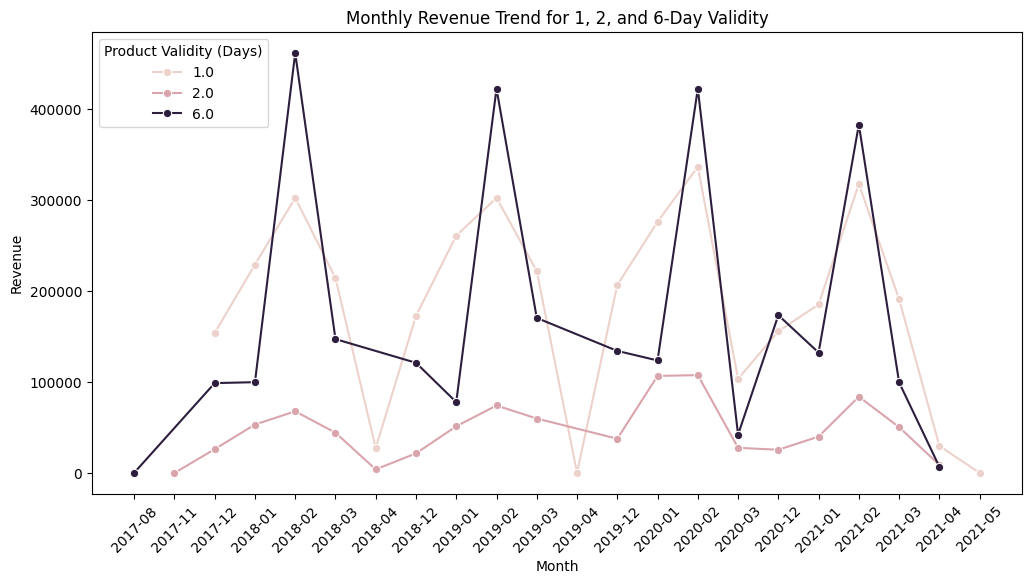

In [ ]:
# Keep only validity values of 1, 2, or 6 days
filtered_df = df[df['product_validity'].isin([1, 2, 6])]

# Create month column
filtered_df['month'] = filtered_df['bought_at'].dt.to_period('M').astype(str)

# Group by month and product_validity
validity_sales = (
    filtered_df.groupby(['month', 'product_validity'])['ticket_price']
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=validity_sales,
    x='month',
    y='ticket_price',
    hue='product_validity',
    marker='o'
)
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend for 1, 2, and 6-Day Validity")
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.legend(title='Product Validity (Days)')
plt.show()


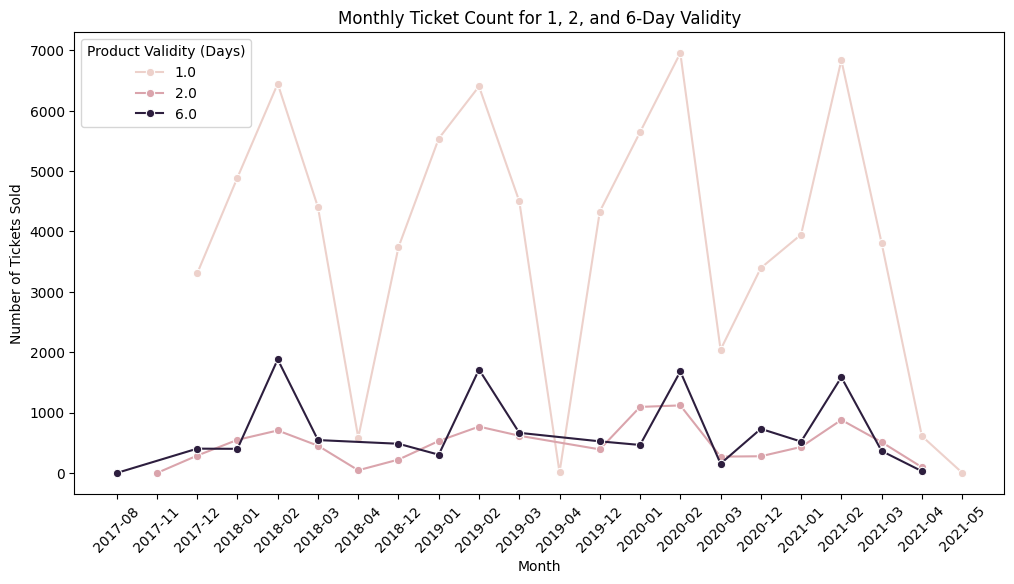

In [ ]:
# Keep only validity values of 1, 2, or 6 days
filtered_df = df[df['product_validity'].isin([1, 2, 6])]

# Create month column
filtered_df['month'] = filtered_df['bought_at'].dt.to_period('M').astype(str)

# Group by month and product_validity, and count tickets
ticket_counts = (
    filtered_df.groupby(['month', 'product_validity'])
    .size()  # counts the number of rows (tickets)
    .reset_index(name='ticket_count')
)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=ticket_counts,
    x='month',
    y='ticket_count',
    hue='product_validity',
    marker='o'
)
plt.xticks(rotation=45)
plt.title("Monthly Ticket Count for 1, 2, and 6-Day Validity")
plt.ylabel("Number of Tickets Sold")
plt.xlabel("Month")
plt.legend(title='Product Validity (Days)')
plt.show()


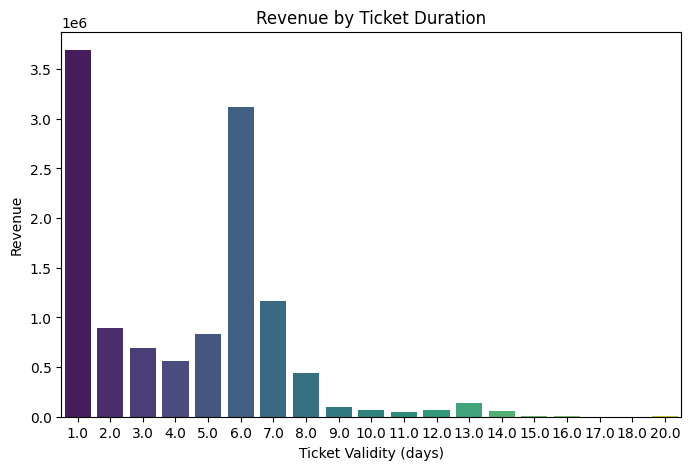

In [ ]:
#Tickets sold by validity (number of days)

validity_sales = df.groupby('product_validity')['ticket_price'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=validity_sales, x='product_validity', y='ticket_price', palette="viridis")
plt.title("Revenue by Ticket Duration")
plt.xlabel("Ticket Validity (days)")
plt.ylabel("Revenue")
plt.show()

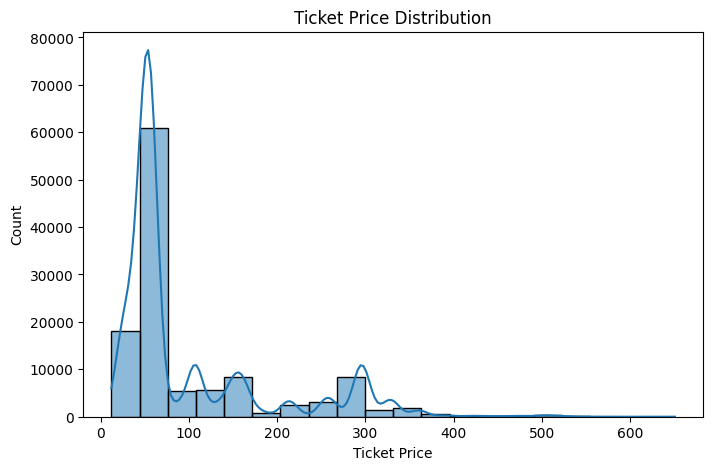

In [ ]:
#Distribution of ticket prices

plt.figure(figsize=(8,5))
sns.histplot(df['ticket_price'], bins=20, kde=True)
plt.title("Ticket Price Distribution")
plt.xlabel("Ticket Price")
plt.ylabel("Count")
plt.show()

# combination

/tmp/ipython-input-3046514260.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price, x='product_validity', y='ticket_price', palette="viridis")


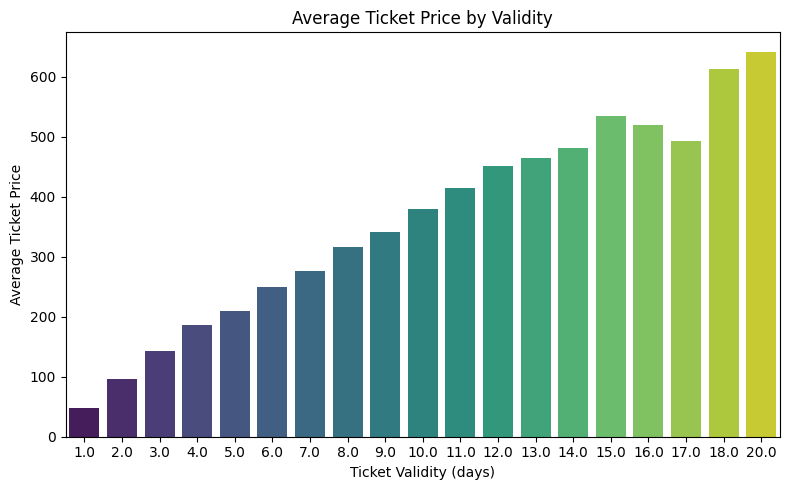

In [ ]:
avg_price = df.groupby('product_validity')['ticket_price'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avg_price, x='product_validity', y='ticket_price', palette="viridis")

plt.title("Average Ticket Price by Validity")
plt.xlabel("Ticket Validity (days)")
plt.ylabel("Average Ticket Price")
plt.tight_layout()
plt.show()


# Customer Insights

In [ ]:
repeat_customers = df ['id'].value_counts()
repeat_rate = sum(repeat_customers > 1) / len(repeat_customers)
print(f"Repeat customer rate: {repeat_rate:.2%}")

Repeat customer rate: 88.40%


#  Heatmap

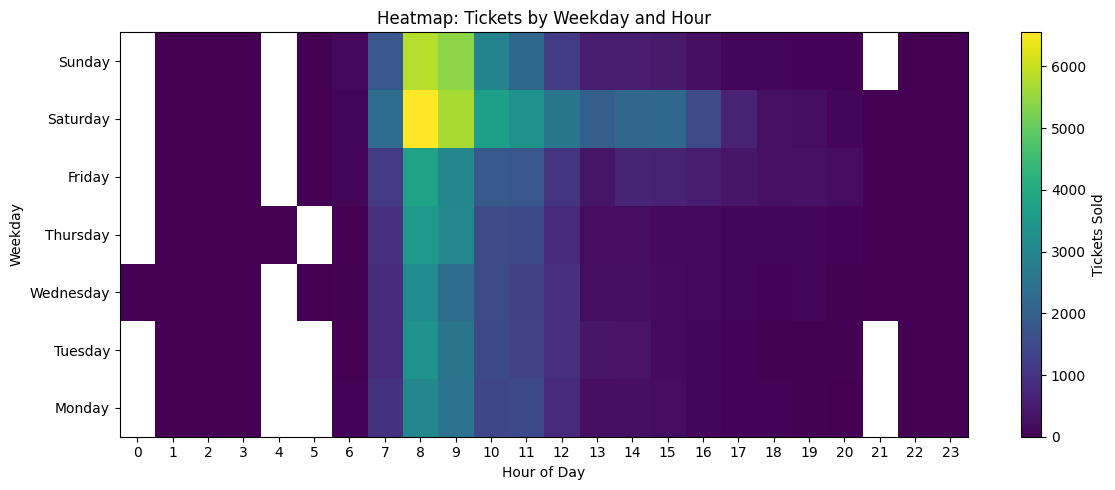

In [ ]:
df['hour'] = df['bought_at'].dt.hour.astype(int)
df['weekday'] = df['bought_at'].dt.day_name()

weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

pivot = df.pivot_table(
    index='weekday',
    columns='hour',
    values='id',
    aggfunc='count'
).reindex(weekday_order).reindex(columns=range(0,24), fill_value=0)

plt.figure(figsize=(12,5))
plt.imshow(pivot, aspect='auto', origin='lower')
plt.colorbar(label='Tickets Sold')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.title('Heatmap: Tickets by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()


#Monthly seasonality pivot


Monthly seasonality pivot (years x months):
bought_at      1        2       3      4    5   6   7    8   9   10   11  \
bought_at                                                                  
2017          NaN      NaN     NaN    NaN  NaN   0   0  1.0   0   0  1.0   
2018       6760.0  11027.0  6503.0  638.0  NaN   0   0  NaN   0   0  NaN   
2019       7151.0  11234.0  6816.0   11.0  NaN   0   0  NaN   0   0  NaN   
2020       8107.0  12050.0  2809.0    4.0  NaN   0   0  NaN   0   0  NaN   
2021       5521.0  11479.0  5536.0  864.0  6.0   0   0  NaN   0   0  NaN   

bought_at      12  
bought_at          
2017       4645.0  
2018       5470.0  
2019       6178.0  
2020       4935.0  
2021          NaN  


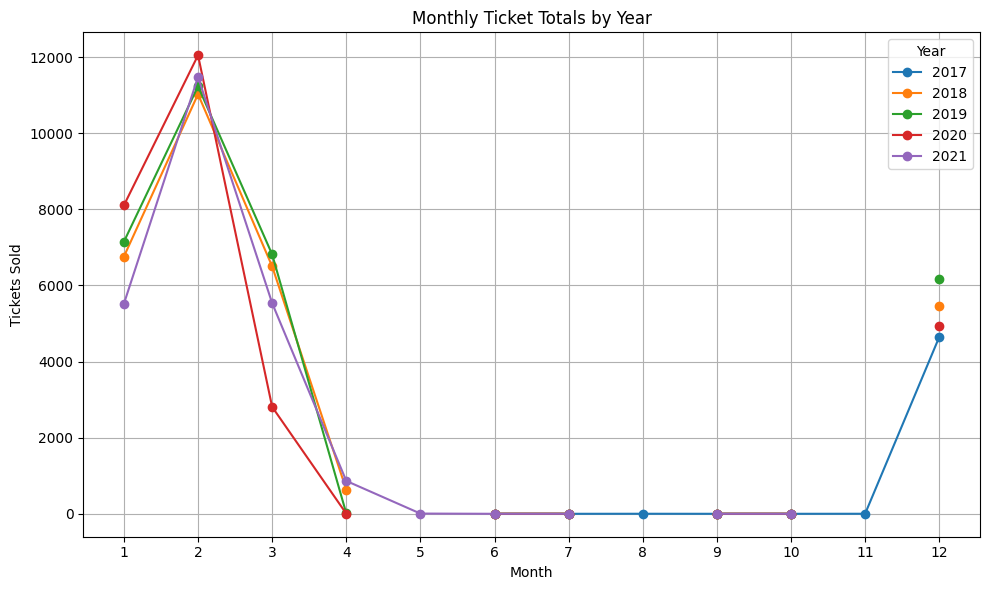

In [ ]:

season_pivot = df.pivot_table(
    index=df['bought_at'].dt.year,
    columns=df['bought_at'].dt.month,
    values='id',
    aggfunc='count'
).reindex(columns=range(1,13), fill_value=0)

print('\nMonthly seasonality pivot (years x months):')
print(season_pivot)

plt.figure(figsize=(10,6))
for y in season_pivot.index:
    plt.plot(range(1,13), season_pivot.loc[y].values, marker='o', label=str(int(y)))
plt.title('Monthly Ticket Totals by Year')
plt.xlabel('Month')
plt.ylabel('Tickets Sold')
plt.xticks(range(1,13))
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


#Top 5 busiest dates (tickets)


In [ ]:


df['date'] = df['bought_at'].dt.date
daily = df.groupby('date').size().reset_index(name='tickets')
top5 = daily.sort_values('tickets', ascending=False).head(5)
print('\nTop 5 busiest dates (tickets):')
print(top5)



Top 5 busiest dates (tickets):
           date  tickets
257  2019-12-28     1247
306  2020-02-15     1141
410  2021-02-20     1138
67   2018-02-10     1136
192  2019-02-16     1135


# Dayli ticket sold

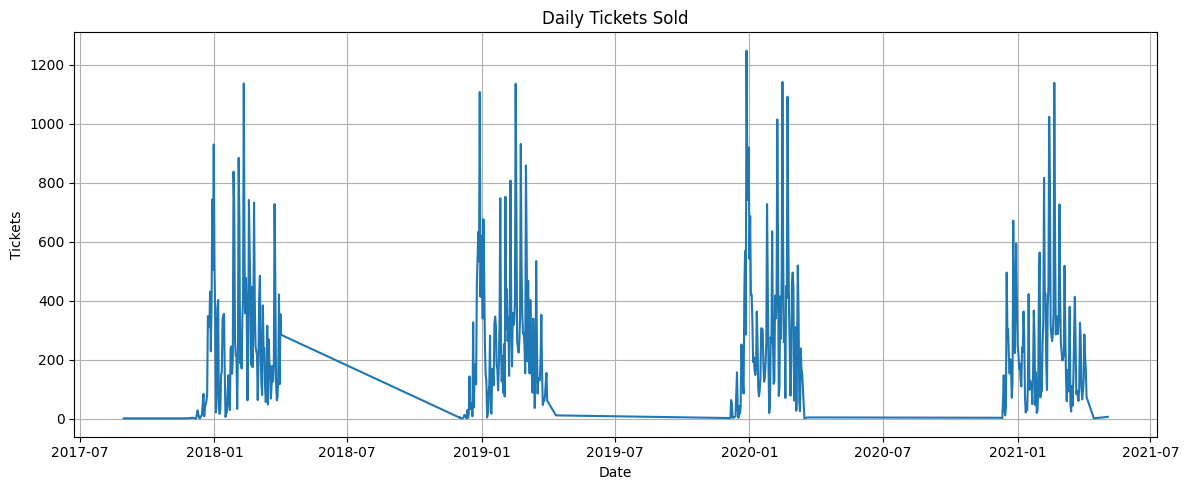

In [ ]:
plt.rcParams['figure.figsize'] = (12,5)

daily.set_index('date', inplace=True)

plt.figure()
plt.plot(daily.index, daily['tickets'].values)
plt.title('Daily Tickets Sold')
plt.xlabel('Date')
plt.ylabel('Tickets')
plt.grid(True)
plt.tight_layout()
plt.show()

# My Suggestion on how to improve pricing and ticketing strategies are:



*    Dynamic Pricing: Adjust ticket prices based on demand patterns (peak season, weekends, holidays) to maximize revenue.
*   Segmented Pricing: Offer different prices for customer categories (adults, children, seniors) and purchase timing (early bird vs last-minute).
*   Revenue Optimization: Use historical sales, seasonality, and hourly trends to forecast demand and set optimal prices.
*   Upselling & Bundles: Encourage multi-day passes or package deals to increase average revenue per customer.
*   Price Elasticity Analysis: Test how demand responds to price changes and adjust pricing strategy accordingly.

# Potential other analyzes / investigations you would have done with more time:

*  Demand Forecasting: Build time series models (ARIMA, Prophet, LSTM) to predict daily/monthly ticket sales for dynamic pricing.
*   Price Elasticity and A/B Testing: Use regression or ML models to estimate how price changes impact demand, and validate with A/B tests or hypothesis testing.
*   Customer Segmentation and Targeting: Apply clustering (K-Means, DBSCAN) to identify behavioral groups for personalized pricing.
*   Churn Prediction and Retention: Train classification models to predict which customers are likely to not return and optimize retention campaigns.
*   Revenue Optimization and Anomaly Detection: Simulate pricing scenarios to maximize revenue and detect unusual sales patterns with ML.










In [ ]:

# Churn Prediction

df["bought_at"] = pd.to_datetime(df["bought_at"], errors="coerce")

# Define churn threshold (e.g. 60 days of inactivity)
today = df["bought_at"].max()
churn_threshold = 60
churn_cutoff = today - timedelta(days=churn_threshold)

rfm = df.groupby("id").agg(
    last_purchase=("bought_at", "max"),
    frequency=("id", "count"),
    monetary=("ticket_price", "sum")
)
rfm["recency_days"] = (today - rfm["last_purchase"]).dt.days

# Label churn (1 = churned, 0 = active)
rfm["churned"] = (rfm["recency_days"] > churn_threshold).astype(int)


X = rfm[["recency_days", "frequency", "monetary"]]
y = rfm["churned"]

X["frequency_log"] = np.log1p(X["frequency"])
X["monetary_log"] = np.log1p(X["monetary"])

features = ["recency_days", "frequency_log", "monetary_log"]

X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.3, random_state=42, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0],
}).sort_values("Coefficient", ascending=False)
print("Model Coefficients (Interpretation):")
print(coef_df)


rfm["churn_prob"] = model.predict_proba(X[features])[:, 1]
top_churn = rfm.sort_values("churn_prob", ascending=False).head(10)
print(" Top 10 Customers Most Likely to Churn:")
print(top_churn[["frequency", "monetary", "recency_days", "churn_prob"]])


Model Coefficients (Interpretation):
         Feature  Coefficient
0   recency_days     3.996850
2   monetary_log     0.011447
1  frequency_log    -0.169040
 Top 10 Customers Most Likely to Churn:
       frequency  monetary  recency_days  churn_prob
id                                                  
57054          5     701.0            70         1.0
57053          6     496.0            70         1.0
57052          7     417.0            70         1.0
57051          3     381.0            70         1.0
57050          6     495.0            70         1.0
57049          7     464.0            70         1.0
57048         10     680.0            70         1.0
57047          9     530.0            70         1.0
57046          6     281.0            70         1.0
57045         10     789.0            70         1.0
